In [1]:
import pandas as pd
import time
import os
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from collections import deque
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense ,Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping
from tensorflow.keras.models import Sequential


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/stech
df = pd.read_csv('GOOGL5.csv')
df.drop(df.columns[[0,8]], axis = 1, inplace =True)
# df['Symbol'] = 'AAPL'

df = df.iloc[13:4013]
# df = df.set_index('ngay')
#df = df.iloc[::-1]     # dao nguoc df
#df = df[['ngay','close','open']]

df.reset_index(inplace =True)
df.drop('index', axis = 1, inplace = True)
df.head(50)


/content/drive/MyDrive/stech


,ngay,open,high,low,close,adjclose,volume,RSI,SMA,EMA,WMA,MOM,atr
0,9/22/2004,58.758759,59.894894,58.463463,59.249249,59.249249,7581211,704146,556698,564572,572200,83809,1.742814
1,9/23/2004,59.479481,61.376377,58.568569,60.470470,60.470470,8535656,721525,564894,570293,579353,81953,1.820749
2,9/24/2004,60.530533,62.112110,59.939941,59.974976,59.974976,9123467,746845,574674,576917,586958,97802,1.889389
3,9/27/2004,59.839840,60.500500,58.958958,59.189190,59.189190,7066127,700029,581159,581050,591500,64850,1.914057
4,9/28/2004,60.710712,63.763763,60.165165,63.493492,63.493492,16929054,721874,588035,585882,596312,68762,2.150364
5,9/29/2004,63.413414,67.577576,63.178177,65.605606,65.605606,30516453,781653,596045,594742,604780,80097,2.403475
6,9/30/2004,65.015015,66.216217,64.564568,64.864868,64.864868,13758028,810059,604852,605062,614863,88067,2.333405
7,10/1/2004,65.465462,67.187187,64.514519,66.356354,66.356354,15124860,817128,613067,614328,624168,82154,2.414199
8,10/4/2004,67.692696,68.503502,67.082085,67.597595,67.597595,13022764,848289,622258,625990,636059,91909,2.381309
9,10/5/2004,67.397400,69.334335,66.186188,69.254257,69.254257,14973212,826777,629510,634971,645719,72524,2.462104


In [8]:
# Window size or the sequence length
N_STEPS = 45
# lookup step, 1 is the next day
LOOKUP_STEP = 5

# Whether to REF feature columns or not
RFE_1 = True
# Whether to PCA or not
PCA_1 = True

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# Whether to shuffle the dataset
SHUFFLE = False
shuffle_str = f"sh-{int(SHUFFLE)}"
# TEST ratio size , 0.2 is 20 %
TEST_SIZE =0.2
# whether to split the training/testing set by date
SPLIT_BY_DATE = True
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# feature to use
# feature_columns = list(df.columns)
# feature_columns.remove('Symbol')
# feature_columns.remove('ngay')

# date now 
date_now = time.strftime("%Y-%m-%d")

# model parameters

N_LAYERS  = 4
#LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# DROPOUT
DROPOUT = 0.2
# Whether to use bidirectional RNNs
BIDIRECTIONAL = False

#  training parameters
# mean absolute error loss
# LOSS = 'mae'
# Huber loss
LOSS = 'huber_loss'
OPTIMIZER = 'rmsprop'
BATCH_SIZE = 32
EPOCHS = 1

# Telsa stock market
ticker = 'TSLA'
ticker_data_file = os.path.join('data', f"{ticker}_{date_now}.csv")
# model name to save ,making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [9]:
def shuffle_in_unison(a,b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


In [10]:
def FE_and_RFE(df , scale = SCALE ,RFE_1 = RFE_1,  n_select = 8, PCA_1 = PCA_1,
               shuffle = True, lookup_steps = LOOKUP_STEP):
    
    # this will contain all the elements we want to return from this function
    result = {}
    # we will alse return the original df itself
    result['df'] = df.copy()
    
    # create feature columns
    feature_columns = df.columns.tolist()
    feature_columns.remove('ngay')
    # feature_columns.remove('Symbol')  # remove for scaler mothod is just for numerical
    
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis =1))
            column_scaler[column] = scaler
            
        # add the MinMaxScale r intances to the result returned
        result['column_scaler'] = column_scaler
        
    # last 'lookup_step' columns contains NaN in future column

    # add the target column (label) by shifting by 'lookup_step'
    df['future'] = df['close'].shift(-lookup_steps)
    
    # get last sequence 
    last_sequence = df[feature_columns].tail(lookup_steps)
    
    result['last_sequence'] = last_sequence
#         # drop NaNs
    df.dropna(inplace =True)
    ###############################
    X = df.iloc[:, 1:26]
    y = df['future']

    #X_train, X_test , y_train , y_test = train_test_split(X, y ,test_size =0.2,
                                                  #  random_state = 42)

    # def RFE():
        #After the feature extension above, we explore the most effective i features by using the Recursive Feature Elimination
        # (RFE) algorithm [6]. We estimate all the features by two attributes, coefficient, and feature importance.
        #We also limit the features that remove from the pool by one, which means we will remove one feature at each step and 
        # retain all the relevant features. Then the output of the RFE block will be the input of the next step, which refers to PCA.'''
    if RFE_1:
        estimator = SVR(kernel = 'linear')
        selector = RFE(estimator , n_features_to_select = n_select, step = 1)

        # fit RFE
        selector.fit(X,y)

        # print(selector.support_)
        # print(selector.ranking_)
        f = selector.get_support(1)
        result['principal_Df'] = df[df.columns[f]]     # create df from selected columns
        # result['principal_Df']['future'] = df['future']
    
        result['principal_Df'] = result['principal_Df'].iloc[:, 1:]

        # create columns of result['principal_Df]
        lit_columns = result['principal_Df'].columns.tolist()

    result['principal_Df'] = pd.concat([result['principal_Df'], result['last_sequence'][lit_columns]], axis = 0)
     
    x = result['principal_Df'].values
    if PCA_1:
        pca = PCA(n_components = 6)
        PCA_result = pca.fit_transform(x)
        result['principal_Df'] = pd.DataFrame(data = PCA_result,
                                  columns = ['pc1','pc2','pc3','pc4','pc5','pc6'])

        # add result['last_sequence']

        result['last_sequence'] = result['principal_Df'].iloc[-LOOKUP_STEP: , :]
        # add new result_principal_Df

        result['principal_Df']  = result['principal_Df'].iloc[:-LOOKUP_STEP , :]

        result['principal_Df']['future']= df['future'] # add column
    
    if 'ngay' not in result['principal_Df'].columns:
        result['principal_Df']['ngay'] = df['ngay']
    
    return result
    # X là dataframe đã được FeatureExpand & RFE

In [11]:
result_1 = FE_and_RFE(df)
result_1['last_sequence']

,pc1,pc2,pc3,pc4,pc5,pc6
3990,1.644462,0.087582,0.006717,0.009197,-0.001657,0.003553
3991,1.645874,0.091823,0.003405,0.018673,0.006758,0.001577
3992,1.611888,0.110295,0.027138,-0.002795,0.005957,-0.006440
3993,1.608665,0.101023,0.024317,-0.001528,-0.005594,0.000332
3994,1.596717,0.094791,0.024203,-0.004351,-0.004333,0.000151


In [ ]:
# df_after_RFE = df_after_RFE.set_index('ngay')

In [ ]:
# feature_columns = df.columns.tolist()
# feature_columns

In [ ]:

def load_data(result_1 , n_steps = 50, shuffle = False, lookup_steps =5,scale =True,
             split_by_date = True, test_size = 0.2):
    
    # create dict that contain all the elements we want to return from this function
    result = {}
    # we wil also return the original dataframe itself
    # result['df'] = result_1['after_RFE'].copy()
    
    
    
    ######### PART1: MinMax_Scaler 
    
    feature_columns = result_1['principal_Df'].columns.tolist()
    # feature_columns.remove('future')
    feature_columns.remove('ngay') #  remove target variable
    feature_columns.remove('future')
    # create df contain feature_columns
    result['feature_columns'] = feature_columns
    
    
    # create for final_data
    lit_columns = result_1['df'].columns.tolist()
    
    result['df'] = result_1['df'][lit_columns + ['ngay']]
    ##################################### PART2: 
    
    # add date as a column
    if 'date' not in result_1['principal_Df'].columns:
        result_1['principal_Df']['date'] = result_1['principal_Df'].index
    
    # get last sequence 
    last_sequence = np.array(result_1['last_sequence'])
    
    # drop NaNs
    result_1['principal_Df'].dropna(inplace =True)
    
    
    sequence_data = []
    sequences = deque(maxlen = n_steps)
    
    for entry, target in zip(result_1['principal_Df'][feature_columns + ['date']].values,
                            result_1['principal_Df']['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
     # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    
    # add to result
    result['last_sequence']  = last_sequence
    
    # Contruct the X's and y's
    X, y = [], []
    for seq , target in sequence_data:
        X.append(seq)
        y.append(target)
        
    # convert to numpy array
    X = np.array(X)
    y = np.array(y)
    
    # result['X'] = X
    
    if split_by_date:
        # # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        
        result['X_train'] = X[:train_samples]
        result['y_train'] = y[:train_samples]
        result['X_test'] = X[train_samples:]
        result['y_test'] = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result['X_train'], result['y_train'])
            shuffle_in_unison(result['X_test'], result['y_test'])
    else:
        # split the dataset randomly
        result['X_train'], result['X_test'], result['y_train'], result['y_test'] = train_test_split(X, y,
                                               test_size = test_size, shuffle = shuffle)
    # get the list of test set dates
    dates = result['X_test'][:, -1, -1]
    # retrieve test features from the original fdf
    result['test_df'] = result['df'].loc[dates]
    # remove duplicated dates in the testing df
    result['test_df'] = result['test_df'][~result['test_df'].index.duplicated(keep = 'first')]
    # remove dates from the training/tesing set && convert to float 32
    result['X_train'] = result['X_train'][:,:,:len(feature_columns)].astype(np.float32)
    result['X_test'] = result['X_test'][:,:,:len(feature_columns)].astype(np.float32)
    
    return result


In [ ]:
def create_model(sequence_length ,  n_features, units = 256, cell = LSTM,
                n_layers = N_LAYERS,dropout= 0.2, loss ='mean_absolute_error',
                optimizer = 'adam', bidirectional = False):
    model = Sequential()
    for i in range(n_layers):
        if i ==0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences = True),
            batch_input_shape = (None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences = True,
                batch_input_shape = (None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences = False)))
            else:
                model.add(cell(units, return_sequences =False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences = True)))
            else:
                model.add(cell(units, return_sequences =True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = loss, metrics = ['mean_absolute_error'], optimizer = optimizer)
    return model

In [ ]:
# ceate these folders if they does not exist
if not os.path.isdir('results'):
    os.mkdir('results')
if not os.path.isdir('logs'):
    os.mkdir('logs')
if not os.path.isdir('data'):
    os.mkdir('data')
    
# load the data
data = load_data( result_1  , N_STEPS ,scale = SCALE, split_by_date = SPLIT_BY_DATE,
                shuffle = SHUFFLE , lookup_steps = LOOKUP_STEP,test_size =TEST_SIZE)
# save the dataframe
data['df'].to_csv(ticker_data_file)

# construct the model
model = create_model(N_STEPS, len(data['feature_columns']), loss = LOSS, units = UNITS, cell=CELL, n_layers = N_LAYERS,
                    dropout =DROPOUT, optimizer = OPTIMIZER, bidirectional = BIDIRECTIONAL)

In [ ]:
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), monitor='val_loss',mode='min', save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=64,
                    epochs=35,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0336
Epoch 00001: val_loss improved from inf to 0.02050, saving model to results/2022-02-09_TSLA-sh-0-sc-1-sbd-1-huber_loss-rmsprop-LSTM-seq-45-step-5-layers-4-units-256.h5
50/50 [==============================] - 5s 88ms/step - loss: 0.0013 - mean_absolute_error: 0.0336 - val_loss: 0.0205 - val_mean_absolute_error: 0.1970
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 9.3293e-04 - mean_absolute_error: 0.0313
Epoch 00002: val_loss improved from 0.02050 to 0.00330, saving model to results/2022-02-09_TSLA-sh-0-sc-1-sbd-1-huber_loss-rmsprop-LSTM-seq-45-step-5-layers-4-units-256.h5
50/50 [==============================] - 4s 81ms/step - loss: 9.3293e-04 - mean_absolute_error: 0.0313 - val_loss: 0.0033 - val_mean_absolute_error: 0.0721
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 6.3065e-04 - mean_absolute_error: 0.0258
Epoch 00003: val_loss did 

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    #This function plots true close price along with predicted close price
    # with blue and red colors respectively
    
    plt.plot(test_df[f'true_close_{LOOKUP_STEP}'], c = 'b')
    plt.plot(test_df[f'close_{LOOKUP_STEP}'], c = 'r')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend(['Actual Price', 'Predicted Price'])
    plt.show()
# data['test_df']

In [ ]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(result_1["column_scaler"]["close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(result_1["column_scaler"]["close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    
    return final_df

In [ ]:
import datetime
today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)
today = str(today)
yesterday = str(yesterday)

lit = []
def predict(model, data):
# retrieve the last sequence from data
  last_sequence = data["last_sequence"][-N_STEPS:]

  # expand dimension
  last_sequence = np.expand_dims(last_sequence, axis=0)
  # print(last_sequence)
  # get the prediction (scaled from 0 to 1)
  prediction = model.predict(last_sequence)
  # get the price (by inverting the scaling)
  if SCALE:
      predicted_price = result_1["column_scaler"]["close"].inverse_transform(prediction)[0][0]
      lit.append(predicted_price)
      high_price = result_1['column_scaler']['high'].inverse_transform(prediction)[0][0]
      lit.append(high_price)
      low_price = result_1['column_scaler']['low'].inverse_transform(prediction)[0][0]
      lit.append(low_price)
  else:
      predicted_price = prediction[0][0]
  return predicted_price
  # print(predicted_price)

In [ ]:
# load optimal model weights from results folder
model_path = os.path.join('results', model_name) + '.h5'
model.load_weights(model_path)

In [ ]:
# evaluate the model
loss , mae = model.evaluate(data['X_test'], data['y_test'], verbose = 0)
# calculate the meanabsolute orro (inverse scaling)
if SCALE:
  mean_absolute_error = result_1['column_scaler']['close'].inverse_transform([[mae]])[0][0]
else:
  mean_absolute_error = mae

In [ ]:
# get the final df for the testing set
final_df = get_final_df(model, data)

# predict the future price
#future_price = predict(model, data)

In [ ]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit']> 0]) + len(final_df[final_df['buy_profit'] > 0]))/ len(final_df)
# calculating total buy & sell profit
total_buy_profit = final_df['buy_profit'].sum()
total_sell_profit = final_df['sell_profit'].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples( number of trades)
profit_per_trade = total_profit / len(final_df)

In [ ]:
# printing metrics
print('GOOGL')
#print(f"Future price after {LOOKUP_STEP} days is {lit[0]}$")
#print(f"highest price after {LOOKUP_STEP} days is {lit[1]}")
#print(f"lowest price after {LOOKUP_STEP} days is {lit[2]}")
# print(final_df['ngay'].loc['2021-12-06'])

#print(f"{LOSS} loss:", loss)
#print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

# BATCH_SIZE = 64
# EPOCHS = 35


GOOGL
Accuracy score: 0.5436156763590392
Total buy profit: 2981.480097600001
Total sell profit: 352.6501420000004
Total profit: 3334.1302396000015
Profit per trade: 4.215082477370419


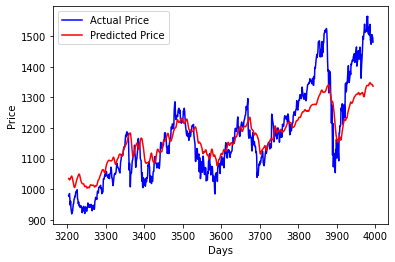

In [ ]:
plot_graph(final_df)

In [ ]:
import datetime
today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)
today = str(today)
yesterday = str(yesterday)
yesterday

'2022-02-08'

In [ ]:
final_df.tail(30)
final_df.set_index('ngay', inplace = True)

In [ ]:
pd.set_option('display.max_rows', None)
final_df

,open,high,low,close,adjclose,volume,RSI,SMA,EMA,WMA,MOM,atr,close_5,true_close_5,buy_profit,sell_profit
ngay,,,,,,,,,,,,,,,,
"(6/14/2017, 6/14/2017)",975.500000,979.700012,959.510010,967.929993,967.929993,1505500,487813,9895550,9834041,9855651,207100,16.940002,1035.286499,978.590027,10.660034,0.000000
"(6/15/2017, 6/15/2017)",948.020019,960.679993,940.369995,960.179993,960.179993,2427600,369482,9852610,9769706,9780133,429400,17.610713,1032.466553,976.619995,16.440002,0.000000
"(6/16/2017, 6/16/2017)",957.909973,959.950012,948.700012,958.619995,958.619995,2559200,425236,9821930,9735051,9730404,306800,17.785710,1030.424316,986.090027,27.470032,0.000000
"(6/19/2017, 6/19/2017)",969.650024,979.299988,968.200012,975.219971,975.219971,1468800,485268,9793690,9728041,9707598,282400,18.815709,1031.495605,972.090027,-3.129944,0.000000
"(6/20/2017, 6/20/2017)",975.309998,980.789978,968.200012,968.989990,968.989990,1297300,512541,9765690,9732598,9700218,280000,18.434993,1033.713989,948.090027,-20.899963,0.000000
"(6/21/2017, 6/21/2017)",970.789978,979.549988,969.450012,978.590027,978.590027,1161600,489526,9737660,9728107,9689711,280300,18.342848,1036.728149,961.010010,-17.580017,0.000000
"(6/22/2017, 6/22/2017)",976.869995,980.500000,973.309998,976.619995,976.619995,1009500,521631,9710300,9735488,9695355,273600,18.184278,1039.411987,937.820007,-38.799988,0.000000
"(6/23/2017, 6/23/2017)",975.500000,986.619995,974.460022,986.090027,986.090027,1564000,513545,9680310,9739035,9703482,299900,18.199275,1042.312134,929.679993,-56.410034,0.000000
"(6/26/2017, 6/26/2017)",990.000000,993.989990,970.330017,972.090027,972.090027,1517900,588552,9711590,9768302,9743425,312800,18.902845,1043.174438,919.460022,-52.630005,0.000000


In [ ]:
# import pickle
# # Save the model to disk
# filename = 'model_92%.sav'
# pickle.dump(model, open(filename, 'wb'))

In [ ]:
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# save df to csv
final_df.to_csv('df_92%.csv')

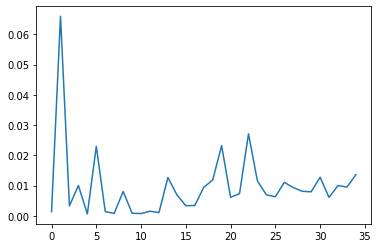

In [ ]:
plt.plot(history.history['val_loss'])